In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

import scipy
from cca.synth_data import embedded_lorenz_cross_cov_mats, oscillators_dynamics_mat, oscillators_cross_cov_mats
from cca import style, ComplexityComponentsAnalysis
from cca.data_util import load_sabes_data, moving_center, calc_autocorr_fns
from cca.cov_util import calc_cross_cov_mats_from_data

In [11]:
NEURAL_DIR = os.path.expanduser("~") + "/Projects/ComplexityComponentsAnalysis/data/sabes/"
SESSION = "indy_20160627_01.mat" 
NEURAL_FILENAME = NEURAL_DIR + SESSION
BIN_WIDTH_S = .100

def load_neural_data():
    res = load_sabes_data(NEURAL_FILENAME, bin_width_s=BIN_WIDTH_S, preprocess=True)
    X, Y = res["M1"], res["cursor"]
    return X, Y

def calc_neg_sqrt(X, min_eigval=1e-5):
    w, V = scipy.linalg.eigh(X)
    if np.min(w) < min_eigval:
        w += (-np.min(w) + min_eigval)
    cov_neg_sqrt = V.dot(np.diag(1. / np.sqrt(w))).dot(V.T)
    return cov_neg_sqrt

def cca_proj(cov_11, cov_12):
    cov_neg_sqrt = calc_neg_sqrt(cov_11)
    to_svd = cov_neg_sqrt.dot(cov_12).dot(cov_neg_sqrt)
    U, s, Vt = scipy.linalg.svd(to_svd)
    V = Vt.T
    U = np.dot(cov_neg_sqrt, U)
    V = np.dot(cov_neg_sqrt, V)
    U /= np.sqrt(np.sum(U**2, axis=0))
    V /= np.sqrt(np.sum(V**2, axis=0))
    return U, V

def sfa_proj(cov_11, cov_12):
    cov_neg_sqrt = calc_neg_sqrt(cov_11)
    cov_sym = cov_12 + cov_12.T
    to_pca = cov_neg_sqrt.dot(cov_sym).dot(cov_neg_sqrt)
    w, V = scipy.linalg.eigh(to_pca)
    V = V[:, np.argsort(np.abs(w))[::-1]]
    V = np.dot(cov_neg_sqrt, V)
    V /= np.sqrt(np.sum(V**2, axis=0))
    return V

def pca_proj(cov):
    _, V = scipy.linalg.eigh(cov)
    V = V[:, ::-1]
    return V

def dca_proj(cov_11, cov_12, d, n_init=1):
    opt = ComplexityComponentsAnalysis(init="random")
    opt.cross_covs = np.array([cov_11, cov_12.T])
    opt.fit_projection(d=d, n_init=n_init)
    V = opt.coef_
    return V

def quad_mat(A, B, C, D):
    top = np.concatenate((A, B), axis=1)
    bottom = np.concatenate((C, D), axis=1)
    mat = np.concatenate((top, bottom), axis=0)
    return mat

def calc_pi(cov_11, cov_12, U, V):
    proj_cov_11 = U.T.dot(cov_11).dot(U)
    proj_cov_22 = V.T.dot(cov_11).dot(V)
    proj_cov_12 = U.T.dot(cov_12).dot(V)
    proj_cov_21 = proj_cov_12.T
    cov_full = quad_mat(proj_cov_11, proj_cov_12, proj_cov_21, proj_cov_22)
    d1 = np.linalg.slogdet(proj_cov_11)[1]
    d2 = np.linalg.slogdet(proj_cov_22)[1]
    d3 = np.linalg.slogdet(cov_full)[1]
    return 0.5 * (d1 + d2 - d3)

def mi_vs_dim(cov_11, cov_12, n_init=100):
    N = cov_11.shape[0]
    method_labels = ["CCA", "DCA", "SFA", "PCA"]
    pi_vals = np.zeros((len(method_labels), N))
    U_cca, V_cca = cca_proj(cov_11, cov_12)
    V_pca = pca_proj(cov_11)
    V_sfa = sfa_proj(cov_11, cov_12)
    for i in range(1, N+1):
        print(i)
        pi_cca = calc_pi(cov_11, cov_12, U_cca[:, :i], V_cca[:, :i])
        V_dca = dca_proj(cov_11, cov_12, i, n_init=n_init)
        pi_dca = calc_pi(cov_11, cov_12, V_dca, V_dca)
        pi_pca = calc_pi(cov_11, cov_12, V_pca[:, :i], V_pca[:, :i])
        pi_sfa = calc_pi(cov_11, cov_12, V_sfa[:, :i], V_sfa[:, :i])
        pi_vals[:, i-1] = [pi_cca, pi_dca, pi_sfa, pi_pca]
    return pi_vals, method_labels


(<matplotlib.axes._axes.Axes at 0x7ff353335470>,
 <matplotlib.axes._axes.Axes at 0x7ff3532dc898>)

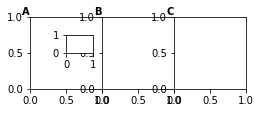

In [21]:
def make_axes(fig_width, fig_height, wpad_edge=0, wpad_mid=0, hpad_bottom=0, hpad_top=0,
              inset_x_rel=0.5, inset_y_rel=0.5, inset_height_rel=0.25):
    fig = plt.figure(figsize=(fig_width, fig_height))    
    ax_height = 1. - hpad_top - hpad_bottom
    ax_width = (1. - 2*wpad_edge - 2*wpad_mid)/3
    
    ax1 = fig.add_axes(( wpad_edge, hpad_bottom, ax_width, ax_height ))
    ax2 = fig.add_axes(( wpad_edge + ax_width + wpad_mid, hpad_bottom, ax_width, ax_height ))
    ax3 = fig.add_axes(( wpad_edge + 2*ax_width + 2*wpad_mid, hpad_bottom, ax_width, ax_height ))
    
    #Make inset
    inset_width_rel = 1.5 * inset_height_rel * (ax_height*fig_height) / (ax_width*fig_width)
    inset_x_abs = wpad_edge + ax_width*inset_x_rel
    inset_y_abs = hpad_bottom + ax_height*inset_y_rel
    inset_width_abs = ax_width*inset_width_rel
    inset_height_abs = ax_height*inset_height_rel
    
    ax_inset = fig.add_axes((inset_x_abs, inset_y_abs, inset_width_abs, inset_height_abs))
    
    
    fig.text(wpad_edge/2, hpad_bottom + ax_height,
             "A", va="bottom", ha="right", color="black",
             **style.panel_letter_fontstyle)
    fig.text(wpad_edge + ax_width + wpad_mid - wpad_edge + wpad_edge/2, hpad_bottom + ax_height,
             "B", va="bottom", ha="right", color="black",
             **style.panel_letter_fontstyle)
    fig.text(wpad_edge + 2*ax_width + 2*wpad_mid - wpad_edge + wpad_edge/2, hpad_bottom + ax_height,
             "C", va="bottom", ha="right", color="black",
             **style.panel_letter_fontstyle)
    
    return ax1, ax_inset, ax2, ax3

def cycle_from_style(scheme):
    return [color_dict["color"] for color_dict in plt.style.library[scheme]['axes.prop_cycle']]

method_colors = ["black", "red", "coral", "gray"]
def plot_mi_vs_dim(mi_vals, labels, ax=None, legend=False, xlabel=False, max_dim=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    num_methods, N = mi_vals.shape
    if max_dim is None:
        max_dim = N
    pi_from_zero = np.concatenate((np.zeros(num_methods).reshape((num_methods, 1)), mi_vals[:, :max_dim]), axis=1)
    dims = np.arange(max_dim + 1)
    max_mi = np.max(mi_vals)
    
    diag_x_vals = np.linspace(0, max_dim, 1000)
    diag_y_vals = (max_mi / max_dim)*diag_x_vals 
    ax.plot(diag_x_vals, diag_y_vals, c="black", linestyle="--", linewidth=1)
    #ypad = 0.05 * max_mi
    ax.set_ylim([0, max_mi*1.05])
    ax.set_xlim([0, max_dim*1.02])
    
    xticks = np.arange(0, max_dim + 1, 5, dtype=np.int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=style.ticklabel_fontsize)
    
    yticks = [0, max_mi]
    max_ylabel = str(np.round(max_mi, 1))
    while len(max_ylabel) < 4:
        max_ylabel = "  " + max_ylabel
    ytick_labels = ["0", max_ylabel]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels, fontsize=style.ticklabel_fontsize)
    ax.tick_params(axis='y', which='major', pad=1)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds(0, max_mi)
    ax.spines['bottom'].set_bounds(0, max_dim)
    
    for i in range(num_methods):
        linewidth = 1 if labels[i] == "CCA" else 0.75
        markersize = 3 if labels[i] == "CCA" else 2
        ax.plot(dims, pi_from_zero[i], label=labels[i], linewidth=linewidth,
                color=method_colors[i], marker=".", markersize=markersize)
    if legend:
        ax.legend(loc="upper left", fontsize=style.ticklabel_fontsize*0.9,
                  frameon=False, ncol=2, labelspacing=0.1, columnspacing=0.55,
                  bbox_to_anchor=(-0.0, 0.025, 1, 1))
    if xlabel:
        ax.set_xlabel("dimensions retained", fontsize=style.axis_label_fontsize, labelpad=1)
    ax.set_ylabel("MI (nats)", fontsize=style.axis_label_fontsize, labelpad=-style.axis_label_fontsize)
    if title is not None:
        ax.set_title(title, fontsize=style.axis_label_fontsize, pad=3)
        
def plot_dca_autocorr_fns(ax, ax_inset, autocorr_1, autocorr_2):
    linewidth = 1
    colors = ["green", "purple"]
    
    ax.plot(autocorr_1, linewidth=linewidth, c=colors[0], label="$T = 1$")#, marker=".", markersize=2)
    ax.plot(autocorr_2, linewidth=linewidth, c=colors[1], label="$T = 20$")#, marker=".", markersize=2)
    ax_inset.plot(autocorr_1[:3], linewidth=linewidth, c=colors[0])#, marker=".", markersize=2*.75)
    ax_inset.plot(autocorr_2[:3], linewidth=linewidth, c=colors[1])#, marker=".", markersize=2*.75)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax_inset.spines['right'].set_visible(False)
    ax_inset.spines['top'].set_visible(False)
    
    #main plot tick labels
    max_dt = 20
    xticks = np.arange(0, max_dt + 1, 5, dtype=np.int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=style.ticklabel_fontsize)
    ax.set_xlim([0, max_dt])
    y_min_main = np.min(np.concatenate((autocorr_1, autocorr_2)))
    y_min_main -= (1 - y_min_main) * .05
    yticks = [y_min_main, 0, 1]
    main_ytick_labels = [np.round(y_min_main, 1), "0.0", "1.0"]
    ax.set_yticks(yticks)
    ax.set_yticklabels(main_ytick_labels, fontsize=style.ticklabel_fontsize)
    ax.set_ylim([y_min_main, 1])
    ax.axhline(0, linestyle="--", linewidth=linewidth, color="black", zorder=0)
    ax.yaxis.set_tick_params(pad=1)
    ax.set_ylabel("autocorrelation", fontsize=style.axis_label_fontsize, labelpad=1)
    ax.set_xlabel("$\Delta t$ (50 ms bins)", fontsize=style.axis_label_fontsize, labelpad=1)
    
    #inset tick labels
    xticks = [0, 1, 2]
    ax_inset.set_xticks(xticks)
    ax_inset.set_xticklabels(xticks, fontsize=style.ticklabel_fontsize*0.75)
    ax_inset.spines['bottom'].set_bounds(0, 2)
    ax_inset.set_xlim([0, 2.065])
    y_min_inset =  np.min(np.concatenate((autocorr_1[:3], autocorr_2[:3])))
    y_min_inset -= (1 - y_min_inset) * .05
    ax_inset.set_ylim([y_min_inset, 1])
    ax_inset.set_yticks([y_min_inset, 1])
    inset_ytick_labels = [np.round(y_min_inset, 1), "1.0"]
    ax_inset.set_yticklabels(inset_ytick_labels, fontsize=style.ticklabel_fontsize*0.75)
    ax_inset.yaxis.set_tick_params(pad=1)
    ax_inset.xaxis.set_tick_params(pad=1)
    ax_inset.axvline(1, c="black", linestyle="--", linewidth=linewidth)
    
    rect = patches.Rectangle((0.15, y_min_inset - 0.01),
                             2, 1 - y_min_inset,
                             linewidth=0.5, edgecolor="black", facecolor="none")
    ax.add_patch(rect)
    ax.arrow(2.5, 0.7, 2, 0.1,  head_width=0.05, head_length=0.5, fc='k', ec='k')
    #ax_inset.set_visible(False)
    ax_inset.set_facecolor([0, 0, 0, 0])
    ax.legend(loc="upper right", fontsize=style.ticklabel_fontsize*0.9,
                  frameon=False, ncol=1, labelspacing=0.1, columnspacing=0.6,
                  bbox_to_anchor=(0.05, 0.175, 1, 1))
        
make_axes(3, 1, wpad_edge=0, wpad_mid=0, hpad_bottom=0, hpad_top=0)


In [16]:
#Analysis 1: get MI vs dim for coupled oscillators and Lorenz attractors

#Get cross-cov mats for all systems
#Lorenz system
lorenz_cross_cov_mats = embedded_lorenz_cross_cov_mats(N=30, T=20, snr=1.)
#Oscillator system (10 oscillators --> 20-dimensional state)
A = oscillators_dynamics_mat(N=10)
osc_cross_cov_mats = oscillators_cross_cov_mats(A, T=20)
#Run the 'MI vs. dimensionality' analysis for both systems
pi_lorenz, labels = mi_vs_dim(lorenz_cross_cov_mats[0], lorenz_cross_cov_mats[10].T, n_init=40)
pi_osc, _ = mi_vs_dim(osc_cross_cov_mats[0], osc_cross_cov_mats[10].T, n_init=200)

np.savez("cached_fig_data/methods_comp.npz", pi_lorenz=pi_lorenz, pi_osc=pi_osc, labels=labels)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [17]:
#Analysis 2: compare DCA and SFA autocorrelation functions on neural data
n_init = 1
T_pi = 20

#Load neural data
X, Y = load_neural_data()
#Calc cross cov mats
opt = ComplexityComponentsAnalysis(init="random")
cross_cov_mats = calc_cross_cov_mats_from_data(X, T=2*T_pi)
#Run DCA for one-time step
opt.cross_covs = cross_cov_mats[:2]
opt.fit_projection(d=1, n_init=n_init)
V1 = opt.coef_
x1 = np.dot(X, V1)
#Run DCA for large time steps
opt.cross_covs = cross_cov_mats
opt.fit_projection(d=1, n_init=n_init)
V2 = opt.coef_
x2 = np.dot(X, V2)
#Calc autocorr functions
autocorr_fn_1 = calc_autocorr_fns(x1, T=T_pi).flatten()
autocorr_fn_2 = calc_autocorr_fns(x2, T=T_pi).flatten()
autocorr_fn_1 /= autocorr_fn_1[0]
autocorr_fn_2 /= autocorr_fn_2[0]

np.savez("cached_fig_data/autocorr_comp.npz", autocorr_fn_1=autocorr_fn_1, autocorr_fn_2=autocorr_fn_2)

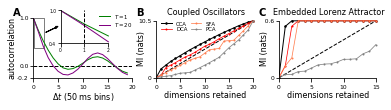

In [22]:
#Plot results!

ax1, ax_inset, ax2, ax3 = make_axes(5.5, 1.25, wpad_edge=0.065, wpad_mid=0.06,
                                    hpad_bottom=0.225, hpad_top=0.11,
                                    inset_x_rel=0.275, inset_y_rel=0.575, inset_height_rel=0.55)

d1 = np.load("cached_fig_data/methods_comp.npz")
pi_lorenz=d1["pi_lorenz"]
pi_osc=d1["pi_osc"]
labels=d1["labels"]

d1 = np.load("cached_fig_data/autocorr_comp.npz")
autocorr_fn_1=d1["autocorr_fn_1"]
autocorr_fn_2=d1["autocorr_fn_2"]

plot_mi_vs_dim(pi_osc, labels, ax2, legend=True, title="Coupled Oscillators", xlabel=True)
plot_mi_vs_dim(pi_lorenz, labels, ax3, max_dim=15, title="Embedded Lorenz Attractor", xlabel=True)
plot_dca_autocorr_fns(ax1, ax_inset, autocorr_fn_1, autocorr_fn_2)

#plt.savefig("figures/methods_comp.pdf")
